# Ambertools-OpenMM Protein-ligand complex MD Setup tutorial using Jupyter Notebook
This notebook took PDB ID 7L10, the protease of SARS-CoV-2 with an inhibitor, as an example, relative work was firstly published on ACS Cent. Sci. 2021, 7, 3, 467–475, by William L. Jorgensen, Yale University.

Ambertools (https://ambermd.org/AmberTools.php) and Openmm (https://openmm.org/) should be properly refer to if any simulation result would be used in any publications.

In [ ]:
#install openmm
!conda install -c conda-forge openmm -y
# install openmm-setup for protein fix and simulation configuration
!conda install -c conda-forge openmm-setup -y
#install open babel
!conda install -c openbabel openbabel -y
# install Amber tools
!conda install -c conda-forge ambertools=21 compilers -y 
#install visualization
! pip install py3Dmol 

In [2]:
!conda env list

# conda environments:
#
base                     /Users/quantaosun/opt/anaconda3
Ambertools-OpenMM-MD  *  /Users/quantaosun/opt/anaconda3/envs/Ambertools-OpenMM-MD



In [3]:
# Change the path to yours
import sys
sys.path.append('/Users/quantaosun/opt/anaconda3/lib/python3.8/site-packages')

# Download your PDB, if the command failed, just mannuly download and skip this.

In [ ]:
# If using MacOS, please install wget by brew, or just mannually download beforehand.

In [9]:
PDB_ID = "7L10" #@param {type:"string"}
pdb = PDB_ID + ".pdb"

In [ ]:
wget https://files.rcsb.org/download/7L10.pdb

# Fix your protein with PDBfixer with OpenMM Setup

In [ ]:
!pdbfixer
#Click the square pause button to force quit after finished.

# Rename processed pdb to "output.pdb"

In [ ]:
#!mv 7L10-processed.pdb output.pdb

# Go to H++, register and process the output.pdb structure, download top and crd. If you leave everything default, you don't need to change anything below. http://newbiophysics.cs.vt.edu/H++/uploadpdb.php

file:///home/sqt/Pictures/Screenshot%20from%202021-12-03%2011-02-08.png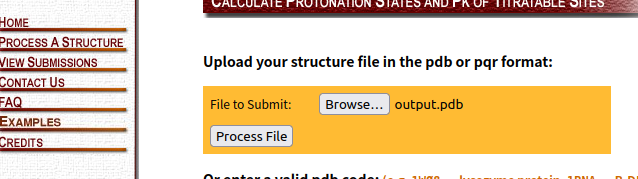

file:///home/sqt/Pictures/Screenshot%20from%202021-12-03%2011-03-21.png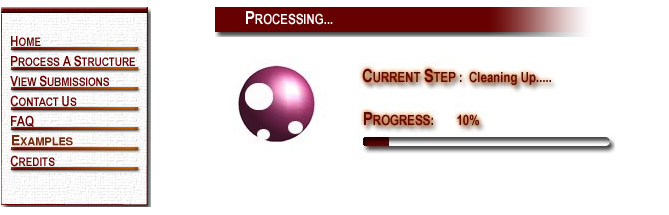

file:///home/sqt/Pictures/Screenshot%20from%202021-12-03%2011-44-00.png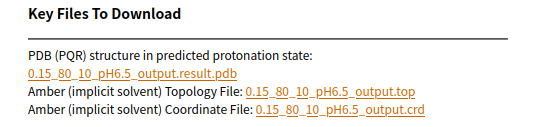

# It is assumed you have save the processed pdb with a name of "output.pdb", otherwise please modifiy commands below.

# Generate protein pdb

In [14]:
!ambpdb -p 0.15_80_10_pH6.5_output.top -c 0.15_80_10_pH6.5_output.crd > 0.pdb

In [15]:
!awk '$4=="XEY"' 7L10.pdb > ligand1.pdb 

# Add hydrogens to you ligand

In [16]:
!obabel -ipdb ligand1.pdb -opdb -O ligand2.pdb -h

1 molecule converted


# Beautify pdb format

In [17]:
!pdb4amber -i ligand2.pdb -o ligand3.pdb


Summary of pdb4amber for: ligand2.pdb

----------Chains
The following (original) chains have been found:
A

---------- Alternate Locations (Original Residues!))

The following residues had alternate locations:
None
-----------Non-standard-resnames
XEY

---------- Mising heavy atom(s)

None


# Generate ligand mol2 file

In [18]:
!antechamber -fi pdb -i ligand3.pdb -fo mol2 -o ligand4.mol2 -c bcc -pf y


Welcome to antechamber 21.0: molecular input file processor.

acdoctor mode is on: check and diagnose problems in the input file.
The atom type is set to gaff; the options available to the -at flag are
    gaff, gaff2, amber, bcc, and sybyl.
-- Check Format for pdb File --
   Status: pass
-- Check Unusual Elements --
   Status: pass
-- Check Open Valences --
   Status: pass
-- Check Geometry --
      for those bonded   
      for those not bonded   
   Status: pass
-- Check Weird Bonds --
   Status: pass
-- Check Number of Units --
   Status: pass
acdoctor mode has completed checking the input file.

Info: Total number of electrons: 214; net charge: 0

Running: /Users/quantaosun/opt/anaconda3/envs/Ambertools-OpenMM-MD/bin/sqm -O -i sqm.in -o sqm.out



# Make sure you see "calculation completed", otherwise something may have been wrong

In [19]:
!tail  sqm.out

  QMMM:    36       36      H        6.5510   -1.5241   19.1879
  QMMM:    37       37      H       11.5057    5.3220   20.3439
  QMMM:    38       38      H       13.0976    5.3912   22.2626
  QMMM:    39       39      H       13.1191    3.5323   23.9318
  QMMM:    40       40      H       11.5651    1.6042   23.6739
  QMMM:    41       41      H        5.4191   -1.8616   27.1518
  QMMM:    42       42      H       10.1573    0.8389   19.6464

           --------- Calculation Completed ----------



# Generate ligand prepi file

In [20]:
!antechamber -i ligand4.mol2 -fi mol2 -o ligand5.prepi -fo prepi -pf y


Welcome to antechamber 21.0: molecular input file processor.

acdoctor mode is on: check and diagnose problems in the input file.
The atom type is set to gaff; the options available to the -at flag are
    gaff, gaff2, amber, bcc, and sybyl.
-- Check Format for mol2 File --
   Status: pass
-- Check Unusual Elements --
   Status: pass
-- Check Open Valences --
   Status: pass
-- Check Geometry --
      for those bonded   
      for those not bonded   
   Status: pass
-- Check Weird Bonds --
   Status: pass
-- Check Number of Units --
   Status: pass
acdoctor mode has completed checking the input file.




# Generate ligand frcmod file

In [21]:
!parmchk2 -f prepi -i ligand5.prepi -o ligand6.frcmod

# Combine protein with ligand again

In [22]:
!cat 0.pdb ligand3.pdb > complex.pdb

# (Not working properly for now) Beautify PDB format, but we might just not need this anyway, skip for now.

In [ ]:
#!pdb4amber -i complex.pdb -o complex_clean.pdb
# This step is problematic for now, it has been observed it is not necessary or even could bring errors to next step.

# Create and run a file called tleap.in with Ambertools

In [23]:
com_file = open('tleap.in','w')
com_file.write('''
source leaprc.protein.ff14SB #Source leaprc file for ff14SB protein force field
source leaprc.gaff #Source leaprc file for gaff
source leaprc.water.tip3p #Source leaprc file for TIP3P water model
loadamberprep ligand5.prepi #Load the prepi file for the ligand
loadamberparams ligand6.frcmod #Load the additional frcmod file for ligand
mol = loadpdb complex.pdb #Load PDB file for protein-ligand complex
solvatebox mol TIP3PBOX 8 #Solvate the complex with a cubic water box
addions mol Cl- 0 #Add Cl- ions to neutralize the system
saveamberparm mol complex.prmtop complex.inpcrd #Save AMBER topology and coordinate files
quit #Quit tleap program
''')
com_file.close()
!tleap -s -f tleap.in > tleap.out

In [ ]:
# check the tleap.out to make sure everything is good
!tail tleap.out

## Start the simulaiton 

In [ ]:
# This script was generated by OpenMM-Setup on 2021-12-15.

from simtk.openmm import *
from simtk.openmm.app import *
from simtk.unit import *

# Input Files

prmtop = AmberPrmtopFile('complex.prmtop')
inpcrd = AmberInpcrdFile('complex.inpcrd')

# System Configuration

nonbondedMethod = PME
nonbondedCutoff = 1.0*nanometers
ewaldErrorTolerance = 0.0005
constraints = HBonds
rigidWater = True
constraintTolerance = 0.000001
hydrogenMass = 1.5*amu

# Integration Options

dt = 0.004*picoseconds
temperature = 300*kelvin
friction = 1.0/picosecond
pressure = 1.0*atmospheres
barostatInterval = 25

# Simulation Options

steps = 1000000
equilibrationSteps = 1000
platform = Platform.getPlatformByName('CPU')
dcdReporter = DCDReporter('trajectory.dcd', 10000)
dataReporter = StateDataReporter('log.txt', 1000, totalSteps=steps,
    step=True, speed=True, progress=True, potentialEnergy=True, temperature=True, separator='\t')
checkpointReporter = CheckpointReporter('checkpoint.chk', 10000)

# Prepare the Simulation

print('Building system...')
topology = prmtop.topology
positions = inpcrd.positions
system = prmtop.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
    constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance, hydrogenMass=hydrogenMass)
system.addForce(MonteCarloBarostat(pressure, temperature, barostatInterval))
integrator = LangevinMiddleIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)
simulation = Simulation(topology, system, integrator, platform)
simulation.context.setPositions(positions)
if inpcrd.boxVectors is not None:
    simulation.context.setPeriodicBoxVectors(*inpcrd.boxVectors)

# Minimize and Equilibrate

print('Performing energy minimization...')
simulation.minimizeEnergy()
print('Equilibrating...')
simulation.context.setVelocitiesToTemperature(temperature)
simulation.step(equilibrationSteps)

# Simulate

print('Simulating...')
simulation.reporters.append(dcdReporter)
simulation.reporters.append(dataReporter)
simulation.reporters.append(checkpointReporter)
simulation.currentStep = 0
simulation.step(steps)